# Reinforcement Learning
### Last workshop: Multi-armed bandit models and RL basic concepts
### This workshop: Finite Markov Decision Process (MDP)
<ul>
<li>Modeling a GridWorld environment</li>
<li>Planning by Dynamic Programming</li>
<li>Policy Iteration</li>
<li>OpenAI gym</li>  
<li>Monte Carlo</li>
<li>Temporal Difference (SARSA, Q-learning)</li>
</ul>

# Requirement
## Markov Decison Process
MDPs are classical formulization of sequential decision making
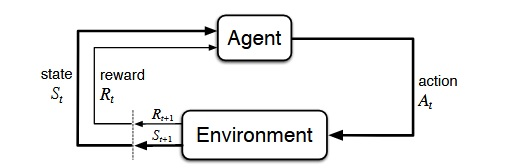
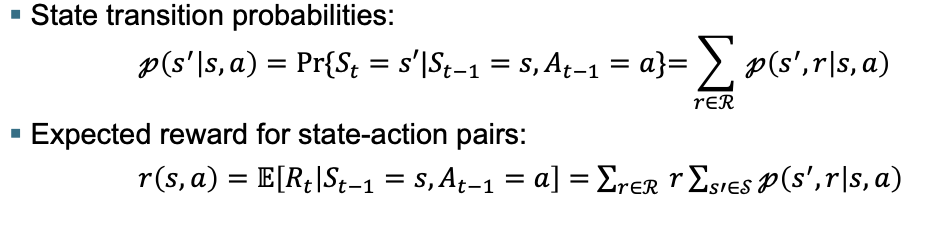

# Policy and Value functions
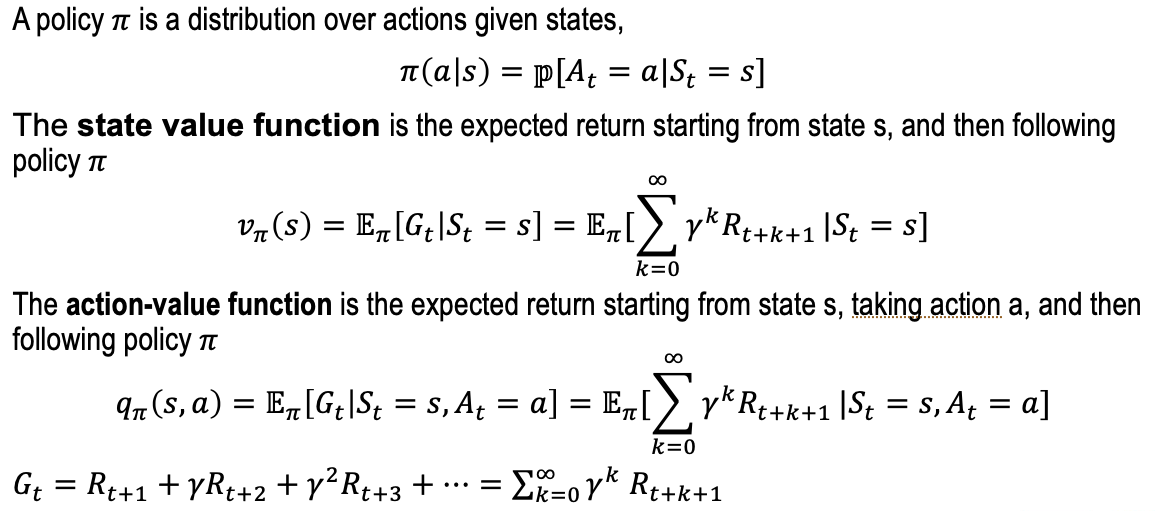

# Bellman expectation equation
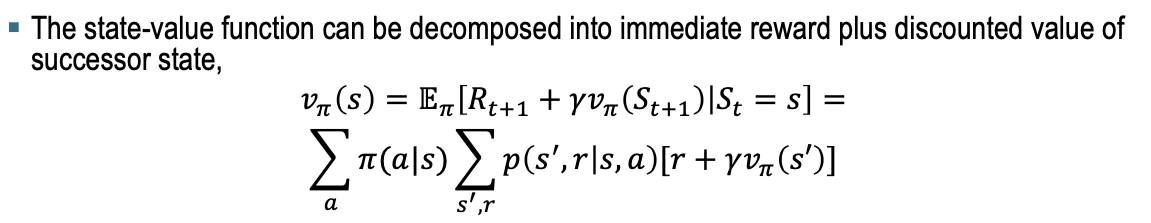

# Solving MDP
## Finding Optimal Policy and Optimal value function
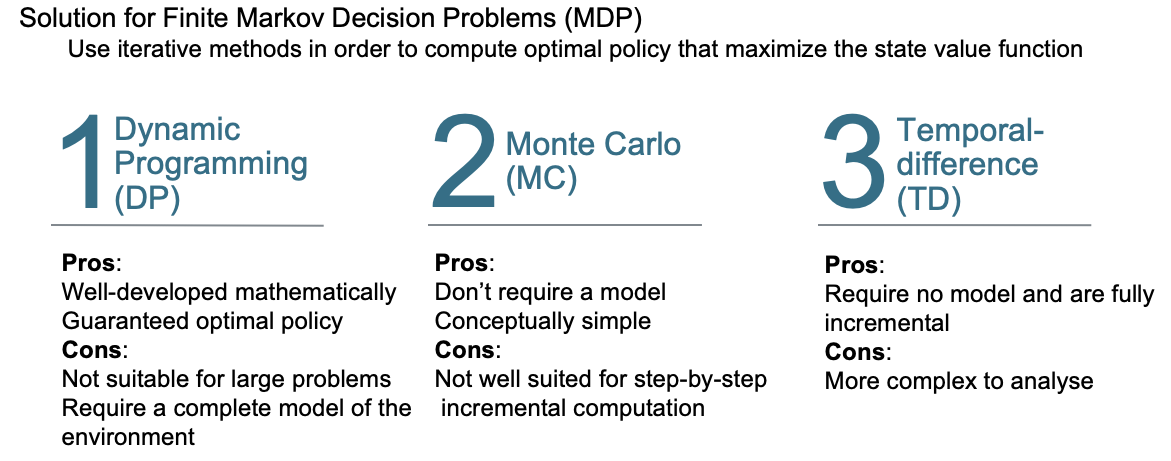

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gym

## GridWorld environment
Each move has a negative reward (-0.1)

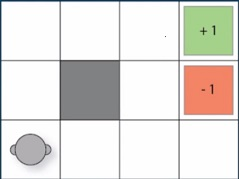


In [3]:
class Grid: # Environment
  def __init__(self, width, height, start):
    self.width = width
    self.height = height
    self.i = start[0]
    self.j = start[1]

  def set(self, rewards, actions):
    # rewards should be a dict of: (i, j): r (row, col): reward
    # actions should be a dict of: (i, j): A (row, col): list of possible actions
    self.rewards = rewards
    self.actions = actions

  def set_state(self, s):
    self.i = s[0]
    self.j = s[1]

  def current_state(self):
    return (self.i, self.j)

  def is_terminal(self, s):
    return s not in self.actions

  def move(self, action):
    # check if legal move first
    if action in self.actions[(self.i, self.j)]:
      if action == 'U':
        self.i -= 1
      elif action == 'D':
        self.i += 1
      elif action == 'R':
        self.j += 1
      elif action == 'L':
        self.j -= 1
    # return a reward (if any)
    return self.rewards.get((self.i, self.j), 0)

  def undo_move(self, action):
    # these are the opposite of what U/D/L/R should normally do
    if action == 'U':
      self.i += 1
    elif action == 'D':
      self.i -= 1
    elif action == 'R':
      self.j -= 1
    elif action == 'L':
      self.j += 1
    # raise an exception if we arrive somewhere we shouldn't be
    # should never happen
    assert(self.current_state() in self.all_states())

  def game_over(self):
    # returns true if game is over, else false
    # true if we are in a state where no actions are possible
    return (self.i, self.j) not in self.actions

  def all_states(self):
    # possibly buggy but simple way to get all states
    # either a position that has possible next actions
    # or a position that yields a reward
    return set(self.actions.keys()) | set(self.rewards.keys())


def standard_grid():
  # define a grid that describes the reward for arriving at each state
  # and possible actions at each state
  # the grid looks like this
  # x means you can't go there
  # s means start position
  # number means reward at that state
  # .  .  .  1
  # .  x  . -1
  # s  .  .  .
  g = Grid(3, 4, (2, 0))
  rewards = {(0, 3): 1, (1, 3): -1}
  actions = {
    (0, 0): ('D', 'R'),
    (0, 1): ('L', 'R'),
    (0, 2): ('L', 'D', 'R'),
    (1, 0): ('U', 'D'),
    (1, 2): ('U', 'D', 'R'),
    (2, 0): ('U', 'R'),
    (2, 1): ('L', 'R'),
    (2, 2): ('L', 'R', 'U'),
    (2, 3): ('L', 'U'),
  }
  g.set(rewards, actions)
  return g


def negative_grid(step_cost=-0.1):
  # in this game we want to try to minimize the number of moves
  # so we will penalize every move
  g = standard_grid()
  g.rewards.update({
    (0, 0): step_cost,
    (0, 1): step_cost,
    (0, 2): step_cost,
    (1, 0): step_cost,
    (1, 2): step_cost,
    (2, 0): step_cost,
    (2, 1): step_cost,
    (2, 2): step_cost,
    (2, 3): step_cost,
  })
  return g


def print_values(V, g):
  for i in range(g.width):
    print("---------------------------")
    for j in range(g.height):
      v = V.get((i,j), 0)
      if v >= 0:
        print(" %.2f|" % v, end="")
      else:
        print("%.2f|" % v, end="") # -ve sign takes up an extra space
    print("")


def print_policy(P, g):
  for i in range(g.width):
    print("---------------------------")
    for j in range(g.height):
      a = P.get((i,j), ' ')
      print("  %s  |" % a, end="")
    print("")

## Dynamic Programming
### We want to solve the GridWorld (Find optimal value function)

## Policy Iteration
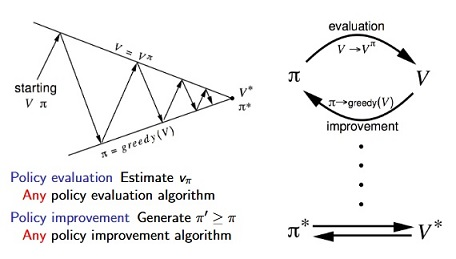

In [4]:
# convergence condition
SMALL_ENOUGH = 1e-3
# learning rate
GAMMA = 0.9
ALL_POSSIBLE_ACTIONS = ('U', 'D', 'L', 'R')
# this grid gives you a reward of -0.1
# to find a shorter path to the goal, use negative grid
grid = negative_grid()
print("rewards:")
print_values(grid.rewards, grid)

rewards:
---------------------------
-0.10|-0.10|-0.10| 1.00|
---------------------------
-0.10| 0.00|-0.10|-1.00|
---------------------------
-0.10|-0.10|-0.10|-0.10|


In [5]:
# state -> action
# choose an action and update randomly 
policy = {}
for s in grid.actions.keys():
    policy[s] = np.random.choice(ALL_POSSIBLE_ACTIONS)

In [6]:
# initial policy
print("initial policy:")
print_policy(policy, grid)

initial policy:
---------------------------
  D  |  R  |  D  |     |
---------------------------
  L  |     |  U  |     |
---------------------------
  L  |  L  |  U  |  D  |


In [7]:
# initialize V(s) - value function
V = {}
states = grid.all_states()
for s in states:
  # V[s] = 0
  if s in grid.actions:
    V[s] = np.random.random()
  else:
    # terminal state
    V[s] = 0

# initial value for all states in grid
print(V)
print_values(V, grid)

{(0, 0): 0.6746668115363322, (1, 3): 0, (2, 1): 0.3048262750052493, (2, 3): 0.6066218997640545, (1, 0): 0.12488426831822519, (0, 3): 0, (0, 1): 0.6926770710081809, (1, 2): 0.8896914707157684, (2, 0): 0.6610611187027744, (2, 2): 0.4342134201745863, (0, 2): 0.7819013476142471}
---------------------------
 0.67| 0.69| 0.78| 0.00|
---------------------------
 0.12| 0.00| 0.89| 0.00|
---------------------------
 0.66| 0.30| 0.43| 0.61|


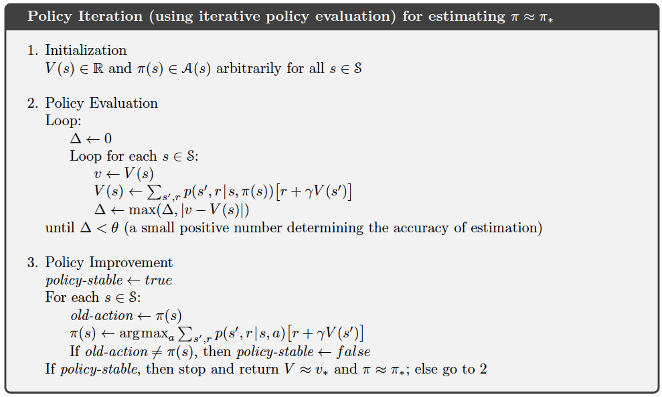

In [8]:
iteration=0
# repeat until convergence
# when policy does not change, it will finish
while True:
  iteration+=1
  print("values %d: " % iteration)
  print_values(V, grid)
  print("policy %d: " % iteration)
  print_policy(policy, grid)

  # policy evaluation step
  while True:
    biggest_change = 0
    for s in states:
      old_v = V[s]

      # V(s) only has value if it's not a terminal state
      if s in policy:
        a = policy[s]
        grid.set_state(s)
        r = grid.move(a) #reward
        V[s] = r + GAMMA * V[grid.current_state()]
        biggest_change = max(biggest_change, np.abs(old_v - V[s]))

    if biggest_change < SMALL_ENOUGH:
      break

  # policy improvement step
  is_policy_converged = True
  for s in states:
    if s in policy:
      old_a = policy[s]
      new_a = None
      best_value = float('-inf')
      # loop through all possible actions to find the best current action
      for a in ALL_POSSIBLE_ACTIONS:
        grid.set_state(s)
        r = grid.move(a)
        v = r + GAMMA * V[grid.current_state()]
        if v > best_value:
          best_value = v
          new_a = a
      policy[s] = new_a
      if new_a != old_a:
        is_policy_converged = False

  if is_policy_converged:
    break

values 1: 
---------------------------
 0.67| 0.69| 0.78| 0.00|
---------------------------
 0.12| 0.00| 0.89| 0.00|
---------------------------
 0.66| 0.30| 0.43| 0.61|
policy 1: 
---------------------------
  D  |  R  |  D  |     |
---------------------------
  L  |     |  U  |     |
---------------------------
  L  |  L  |  U  |  D  |
values 2: 
---------------------------
-0.99|-1.00|-1.00| 0.00|
---------------------------
-0.99| 0.00|-1.00| 0.00|
---------------------------
-0.99|-0.99|-1.00|-0.99|
policy 2: 
---------------------------
  U  |  L  |  R  |     |
---------------------------
  D  |     |  L  |     |
---------------------------
  D  |  U  |  L  |  D  |
values 3: 
---------------------------
-1.00|-1.00| 1.00| 0.00|
---------------------------
-0.99| 0.00|-1.00| 0.00|
---------------------------
-0.99|-0.99|-0.99|-0.99|
policy 3: 
---------------------------
  D  |  R  |  R  |     |
---------------------------
  D  |     |  U  |     |
---------------------------
  U  

In [8]:
print("final values:")
print_values(V, grid)
print("final policy:")
print_policy(policy, grid)

final values:
---------------------------
 0.62| 0.80| 1.00| 0.00|
---------------------------
 0.46| 0.00| 0.80| 0.00|
---------------------------
 0.31| 0.46| 0.62| 0.46|
final policy:
---------------------------
  R  |  R  |  R  |     |
---------------------------
  U  |     |  U  |     |
---------------------------
  U  |  R  |  U  |  L  |


## Task for you
Apply $\epsilon$_greedy policy improvement and compare the results with greedy improvement

In [10]:
# state -> action
# choose an action and update randomly 
policy = {}
for s in grid.actions.keys():
    policy[s] = np.random.choice(ALL_POSSIBLE_ACTIONS)

In [11]:
# initialize V(s) - value function
V = {}
states = grid.all_states()
for s in states:
  # V[s] = 0
  if s in grid.actions:
    V[s] = np.random.random()
  else:
    # terminal state
    V[s] = 0

# initial value for all states in grid
print(V)
print_values(V, grid)

{(0, 0): 0.19039009405414498, (1, 3): 0, (2, 1): 0.5407902359194879, (2, 3): 0.013123131481359795, (1, 0): 0.7457959379852074, (0, 3): 0, (0, 1): 0.6371377857136243, (1, 2): 0.9163478268165165, (2, 0): 0.09490033573535617, (2, 2): 0.9311359682533814, (0, 2): 0.9934447819556}
---------------------------
 0.19| 0.64| 0.99| 0.00|
---------------------------
 0.75| 0.00| 0.92| 0.00|
---------------------------
 0.09| 0.54| 0.93| 0.01|


In [12]:
iteration=0
# repeat until convergence
# when policy does not change, it will finish
while True:
  iteration+=1
  print("values %d: " % iteration)
  print_values(V, grid)
  print("policy %d: " % iteration)
  print_policy(policy, grid)

  # policy evaluation step
  while True:
    biggest_change = 0
    for s in states:
      old_v = V[s]

      # V(s) only has value if it's not a terminal state
      if s in policy:
        a = policy[s]
        grid.set_state(s)
        r = grid.move(a) #reward
        V[s] = r + GAMMA * V[grid.current_state()]
        biggest_change = max(biggest_change, np.abs(old_v - V[s]))

    if biggest_change < SMALL_ENOUGH:
      break

  # policy improvement step
  eps = 0.3
  p = np.random.rand()
  if p < eps:
    is_policy_converged = False
    for s in grid.actions.keys():
      policy[s] = np.random.choice(ALL_POSSIBLE_ACTIONS)
  else:
    is_policy_converged = True
    for s in states:
      if s in policy:
        old_a = policy[s]
        new_a = None
        best_value = float('-inf')
        # loop through all possible actions to find the best current action
        for a in ALL_POSSIBLE_ACTIONS:
          grid.set_state(s)
          r = grid.move(a)
          v = r + GAMMA * V[grid.current_state()]
          if v > best_value:
            best_value = v
            new_a = a
            
        policy[s] = new_a
        if new_a != old_a:
          is_policy_converged = False

  if is_policy_converged:
    break

values 1: 
---------------------------
 0.19| 0.64| 0.99| 0.00|
---------------------------
 0.75| 0.00| 0.92| 0.00|
---------------------------
 0.09| 0.54| 0.93| 0.01|
policy 1: 
---------------------------
  L  |  D  |  D  |     |
---------------------------
  D  |     |  L  |     |
---------------------------
  U  |  R  |  U  |  R  |
values 2: 
---------------------------
-0.99|-0.99|-0.99| 0.00|
---------------------------
-1.00| 0.00|-0.99| 0.00|
---------------------------
-1.00|-0.99|-0.99|-1.00|
policy 2: 
---------------------------
  R  |  R  |  R  |     |
---------------------------
  U  |     |  L  |     |
---------------------------
  R  |  U  |  U  |  L  |
values 3: 
---------------------------
 0.62| 0.80| 1.00| 0.00|
---------------------------
 0.46| 0.00|-0.99| 0.00|
---------------------------
-1.00|-0.99|-0.99|-0.99|
policy 3: 
---------------------------
  L  |  U  |  U  |     |
---------------------------
  D  |     |  D  |     |
---------------------------
  U  

### This is Example 4.3. Gambler’s Problem from Sutton's book.

A gambler has the opportunity to make bets on the outcomes of a sequence of coin flips. 
If the coin comes up heads, he wins as many dollars as he has staked on that flip; 
if it is tails, he loses his stake. The game ends when the gambler wins by reaching his goal of $100, 
or loses by running out of money. 

On each flip, the gambler must decide what portion of his capital to stake, in integer numbers of dollars. 
This problem can be formulated as an undiscounted, episodic, finite MDP. 

The state is the gambler’s capital, s ∈ {1, 2, . . . , 99}.
The actions are stakes, a ∈ {0, 1, . . . , min(s, 100 − s)}. 
The reward is zero on all transitions except those on which the gambler reaches his goal, when it is +1.

The state-value function then gives the probability of winning from each state. A policy is a mapping from levels of capital to stakes. The optimal policy maximizes the probability of reaching the goal. Let p_h denote the probability of the coin coming up heads. If p_h is known, then the entire problem is known and it can be solved, for instance, by value iteration.



Implement value iteration for the gambler’s problem and solve it for p_h = 0.25 and p_h = 0.55.

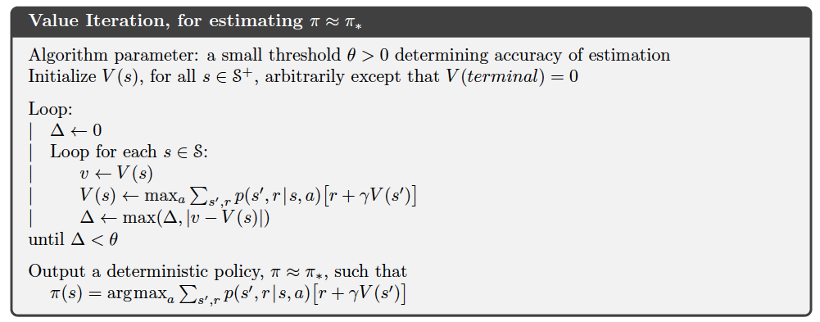

In [13]:
def value_iteration_for_gamblers(p_h, theta=0.0001, discount_factor=1.0):
    """
    Args:
        p_h: Probability of the coin coming up heads
    """
    # The reward is zero on all transitions except those on which the gambler reaches his goal,
    # when it is +1.
    rewards = np.zeros(101)
    rewards[100] = 1
    
    # We introduce two dummy states corresponding to termination with capital of 0 and 100
    V = np.zeros(101)
    
    def one_step_lookahead(s, V, rewards):
        """
        Helper function to calculate the value for all action in a given state.
        
        Args:
            s: The gambler’s capital. Integer.
            V: The vector that contains values at each state. 
            rewards: The reward vector.
                        
        Returns:
            A vector containing the expected value of each action. 
            Its length equals to the number of actions.
        """
        A = np.zeros(101)
        stakes = range(1, min(s, 100-s)+1) # Your minimum bet is 1, maximum bet is min(s, 100-s).
        for a in stakes:
            # rewards[s+a], rewards[s-a] are immediate rewards.
            # V[s+a], V[s-a] are values of the next states.
            # This is the core of the Bellman equation: The expected value of your action is 
            # the sum of immediate rewards and the value of the next state.
            A[a] = p_h * (rewards[s+a] + V[s+a]*discount_factor) + (1-p_h) * (rewards[s-a] + V[s-a]*discount_factor)
        return A
    
    while True:
        # Stopping condition
        delta = 0
        # Update each state...
        for s in range(1, 100):
            # Do a one-step lookahead to find the best action
            A = one_step_lookahead(s, V, rewards)
            # print(s,A,V) # if you want to debug.
            best_action_value = np.max(A)
            # Calculate delta across all states seen so far
            delta = max(delta, np.abs(best_action_value - V[s]))
            # Update the value function. Ref: Sutton book eq. 4.10. 
            V[s] = best_action_value        
        # Check if we can stop 
        if delta < theta:
            break
    
    # Create a deterministic policy using the optimal value function
    policy = np.zeros(100)
    for s in range(1, 100):
        # One step lookahead to find the best action for this state
        A = one_step_lookahead(s, V, rewards)
        best_action = np.argmax(A)
        # Always take the best action
        policy[s] = best_action
    
    return policy, V

In [14]:
policy, v = value_iteration_for_gamblers(0.25)

print("Optimized Policy:")
print(policy)
print("")

print("Optimized Value Function:")
print(v)
print("")

Optimized Policy:
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 12. 11. 15. 16. 17.
 18.  6. 20. 21.  3. 23. 24. 25.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.
 11. 12. 38. 11. 10.  9. 42.  7. 44.  5. 46. 47. 48. 49. 50.  1.  2.  3.
  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 11. 10.  9. 17.  7. 19.  5. 21.
 22. 23. 24. 25.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 12. 11.
 10.  9.  8.  7.  6.  5.  4.  3.  2.  1.]

Optimized Value Function:
[0.00000000e+00 7.24792480e-05 2.89916992e-04 6.95257448e-04
 1.16010383e-03 1.76906586e-03 2.78102979e-03 4.03504074e-03
 4.66214120e-03 5.59997559e-03 7.08471239e-03 9.03964043e-03
 1.11241192e-02 1.56793594e-02 1.61464431e-02 1.69517994e-02
 1.86512806e-02 1.98249817e-02 2.24047303e-02 2.73845196e-02
 2.83388495e-02 3.04937363e-02 3.61633897e-02 3.84953022e-02
 4.44964767e-02 6.25000000e-02 6.27174377e-02 6.33700779e-02
 6.45857723e-02 6.59966059e-02 6.78135343e-02 7.08430894e-02
 7.46098323e-02 7.64884604e-02 7.93035477e-02 8.37541372e-02

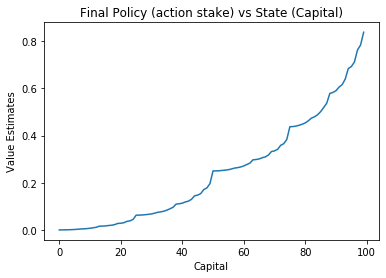

In [15]:
# Plotting Final Policy (action stake) vs State (Capital)

# x axis values
x = range(100)
# corresponding y axis values
y = v[:100]
 
# plotting the points 
plt.plot(x, y)
 
# naming the x axis
plt.xlabel('Capital')
# naming the y axis
plt.ylabel('Value Estimates')
 
# giving a title to the graph
plt.title('Final Policy (action stake) vs State (Capital)')
 
# function to show the plot
plt.show()

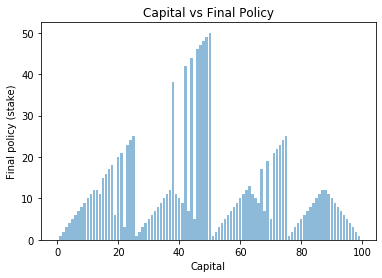

In [16]:
# Plotting Capital vs Final Policy

# x axis values
x = range(100)
# corresponding y axis values
y = policy
 
# plotting the bars
plt.bar(x, y, align='center', alpha=0.5)
 
# naming the x axis
plt.xlabel('Capital')
# naming the y axis
plt.ylabel('Final policy (stake)')
 
# giving a title to the graph
plt.title('Capital vs Final Policy')
 
# function to show the plot
plt.show()

# Open AI gym

Introduction to <a href="https://gym.openai.com/docs/">Open AI gym</a>.

In [17]:
env = gym.make('Taxi-v3')
env.reset()
env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



"There are 4 locations (labeled by different letters), and our job is to pick up the passenger at one location and drop him off at another. We receive +20 points for a successful drop-off and lose 1 point for every time-step it takes. There is also a 10 point penalty for illegal pick-up and drop-off actions."

Action Space Discrete(6)
State Space Discrete(500)
<ul>
<li>The filled square represents the taxi, which is yellow without a passenger and green with a passenger</li>
<li>The pipe ("|") represents a wall which the taxi cannot cross.</li>
<li>R, G, Y, B are the possible pickup and destination locations.</li>
<li>The blue letter represents the current passenger pick-up location, and the purple letter is the current destination.</li>  
</ul>

### actions:
<ol>
<li>south</li>
<li>north</li>
<li>east</li>
<li>west</li>
<li>pickup</li>
<li>dropoff</li>
</ol>

In [18]:
# Let's first do some random steps in the game so you see how the game looks like

rew_tot=0
obs= env.reset()
env.render()
for _ in range(100):
    action = env.action_space.sample() #take step using random action from possible actions (actio_space)
    obs, rew, done, info = env.step(action) 
    rew_tot = rew_tot + rew
    env.render()
#Print the reward of these random action
print("Reward: %r" % rew_tot)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B:

In [19]:
# action space has 6 possible actions, the meaning of the actions is nice to know for us humans but the neural network will figure it out
print(env.action_space)
NUM_ACTIONS = env.action_space.n
print("Possible actions: [0..%a]" % (NUM_ACTIONS-1))

Discrete(6)
Possible actions: [0..5]


In [20]:
print(env.observation_space)
print()
env.env.s=42 # some random number, you might recognize it
env.render()
env.env.s = 222 # and some other
env.render()

Discrete(500)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)


In [21]:
# Value iteration algorithem
NUM_ACTIONS = env.action_space.n
NUM_STATES = env.observation_space.n
V = np.zeros([NUM_STATES]) # The Value for each state
Pi = np.zeros([NUM_STATES], dtype=int)  # Our policy with we keep updating to get the optimal policy
gamma = 0.9 # discount factor
significant_improvement = 0.01

def best_action_value(s):
    # finds the highest value action (max_a) in state s
    best_a = None
    best_value = float('-inf')

    # loop through all possible actions to find the best current action
    for a in range (0, NUM_ACTIONS):
        env.env.s = s
        s_new, rew, done, info = env.step(a) #take the action
        v = rew + gamma * V[s_new]
        if v > best_value:
            best_value = v
            best_a = a
    return best_a

iteration = 0
while True:
    # biggest_change is referred to by the mathematical symbol delta in equations
    biggest_change = 0
    for s in range (0, NUM_STATES):
        old_v = V[s]
        action = best_action_value(s) #choosing an action with the highest future reward
        env.env.s = s # goto the state
        s_new, rew, done, info = env.step(action) #take the action
        V[s] = rew + gamma * V[s_new] #Update Value for the state using Bellman equation
        Pi[s] = action
        biggest_change = max(biggest_change, np.abs(old_v - V[s]))
    iteration += 1
    if biggest_change < significant_improvement:
        print (iteration,' iterations done')
        break

41  iterations done


In [22]:
# Let's see how the algorithm solves the taxi game
rew_tot=0
obs= env.reset()
env.render()
done=False
while done != True: 
    action = Pi[obs]
    obs, rew, done, info = env.step(action) #take step using selected action
    rew_tot = rew_tot + rew
    env.render()
#Print the reward of these actions
print("Reward: %r" % rew_tot)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)
+---------+
|R: | : :G|
| : | : :_|
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : :_|
| | : | : |
|Y| : |B: |

### Q-learning

In [66]:
NUM_ACTIONS = env.action_space.n
NUM_STATES = env.observation_space.n
Q = np.zeros([NUM_STATES, NUM_ACTIONS]) #You could also make this dynamic if you don't know all games states upfront
gamma = 0.9 # discount factor
alpha = 0.9 # learning rate
for episode in range(1,1001):
    done = False
    rew_tot = 0
    obs = env.reset()
    while done != True:
            action = np.argmax(Q[obs]) #choosing the action with the highest Q value 
            obs2, rew, done, info = env.step(action) #take the action
            Q[obs,action] += alpha * (rew + gamma * np.max(Q[obs2]) - Q[obs,action]) #Update Q-marix using Bellman equation
            #Q[obs,action] = rew + gamma * np.max(Q[obs2]) # same equation but with learning rate = 1 returns the basic Bellman equation
            rew_tot = rew_tot + rew
            obs = obs2   
    if episode % 50 == 0:
        print('Episode {} Total Reward: {}'.format(episode,rew_tot))

Episode 50 Total Reward: -5
Episode 100 Total Reward: -130
Episode 150 Total Reward: -64
Episode 200 Total Reward: 13
Episode 250 Total Reward: 6
Episode 300 Total Reward: -24
Episode 350 Total Reward: 7
Episode 400 Total Reward: 11
Episode 450 Total Reward: 11
Episode 500 Total Reward: -1
Episode 550 Total Reward: 7
Episode 600 Total Reward: 4
Episode 650 Total Reward: 4
Episode 700 Total Reward: 9
Episode 750 Total Reward: 9
Episode 800 Total Reward: 9
Episode 850 Total Reward: 7
Episode 900 Total Reward: 11
Episode 950 Total Reward: 3
Episode 1000 Total Reward: 12


In [67]:
# Let's see how the algorithm solves the taxi game by following the policy to take actions delivering max value

rew_tot=0
obs= env.reset()
env.render()
done=False
while done != True: 
    action = np.argmax(Q[obs])
    obs, rew, done, info = env.step(action) #take step using selected action
    rew_tot = rew_tot + rew
    env.render()
#Print the reward of these actions
print("Reward: %r" % rew_tot)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)
+---------+
|R:_| : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
+---------+
|R: | : :G|
| :_| : : |
| : : : : |
| | : | : |
|Y| : |B: |
+